In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn visualization library

import os, sys, re, pickle, glob
drive.mount('/content/drive')

import IPython.display as ipd
from tqdm import tqdm #show a smart progress meter
import librosa # for loading the audio file to TS

from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
final_list=[]

In [ ]:
# Define paths
harrypotter_dir = '/content/drive/MyDrive/Colab Notebooks/ML/MajorProject/Full Data/HarryPotter'
csv_path = '/content/drive/MyDrive/Colab Notebooks/ML/MajorProject/Full Data/MLEndHWD_Audio_Attributes.csv'

# Load the CSV file
audio_data = pd.read_csv(csv_path)

In [ ]:
def get_clean_dataframe(files, song_list, title):
    """
    Create a clean DataFrame by matching file names in the list with corresponding CSV data.
    """
    table = []

    for file in files:
        # Extract file name from the path
        file_name = os.path.basename(file)

        # Match with the CSV data and build the table
        matched_row = audio_data[audio_data['Public filename'] == file_name]

        if not matched_row.empty:
            participant_ID = matched_row.iloc[0]['Interpreter']
            interpretation_type = matched_row.iloc[0]['Interpretation']
            song = matched_row.iloc[0]['Song']

            # Append the matched information to the table
            table.append([file_name, participant_ID, interpretation_type, song])

    # Create a DataFrame from the table
    df = pd.DataFrame(table, columns=['file_id', 'participant', 'interpretation', 'song'])
    return df

In [ ]:
# Get all files in the HarryPotter folder
sample_path = '/content/drive/MyDrive/Colab Notebooks/ML/MajorProject/Full Data/HarryPotter/*.wav'
files_harry = glob.glob(sample_path)
final_list.extend(files_harry)

# Define the correct title of the song
title = 'Harry'

# Define all the possible titles to be found in the file names
song_list = ['Potter', 'potter', 'Harry', 'harry']

Harry_df = get_clean_dataframe(files_harry, song_list, title)

In [ ]:
print(len(files_harry), Harry_df.shape, len(final_list))

838 (838, 4) 838


In [ ]:
Harry_df.head(5)

,file_id,participant,interpretation,song
0,0000.wav,216,Hum,Potter
1,0002.wav,177,Hum,Potter
2,0001.wav,100,Hum,Potter
3,0003.wav,159,Hum,Potter
4,0017.wav,70,Whistle,Potter


In [ ]:
Harry_df.nunique() # checking the unique values in Harry dataframe

,0
file_id,838
participant,222
interpretation,2
song,1


In [ ]:
# Get all files in the StarWars folder
sample_path = '/content/drive/MyDrive/Colab Notebooks/ML/MajorProject/Full Data/StarWars/*.wav'
files_starwars = glob.glob(sample_path)
final_list.extend(files_starwars)

# Define the correct title of the song
title = 'StarWars'

# Define all the possible titles to be found in the file names
song_list = ['StarWars', 'StarWar', 'Star Wars', 'Star war', 'Starwars', 'Imperial', 'starwars', 'StarsWars',
              'star_wars', 'starwar', 'imperial_march', 'STARWAR', 'StartWars', 'StatWars', 'Star wars', 'star wars']

StarWars_df = get_clean_dataframe(files_starwars, song_list, title)

In [ ]:
StarWars_df.head(5)

,file_id,participant,interpretation,song
0,0838.wav,153,Hum,StarWars
1,0840.wav,53,Hum,StarWars
2,0844.wav,150,Whistle,StarWars
3,0845.wav,71,Hum,StarWars
4,0850.wav,80,Whistle,StarWars


In [ ]:
StarWars_df.nunique()

,0
file_id,831
participant,222
interpretation,2
song,1


In [ ]:
print(len(files_harry), Harry_df.shape, len(final_list))

838 (838, 4) 1669


In [ ]:
#creating a final dataframe containing infromation of both Harry and Starwars files:
final_df= pd.concat([Harry_df, StarWars_df], sort=False)
final_df.set_index('file_id', inplace=True)

In [ ]:
final_df

,participant,interpretation,song
file_id,,,
0000.wav,216,Hum,Potter
0002.wav,177,Hum,Potter
0001.wav,100,Hum,Potter
0003.wav,159,Hum,Potter
0017.wav,70,Whistle,Potter
...,...,...,...
1669.wav,181,Hum,StarWars
1666.wav,25,Hum,StarWars
1661.wav,18,Hum,StarWars


In [ ]:
len(final_list)

1669

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y,z =[],[],[]
  # different song lable
  slable= ['Frozen', 'Potter', 'Panther', 'StarWars', 'Rain','Hakuna', 'Mamma']
  for file in tqdm(files):

    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]

    # Feature for interpretation type of the file, True for hum, False for whistle
    y1 = labels_file.loc[fileID]['interpretation'].strip().lower() == 'hum'

    # Feature for type of the song,
    if(labels_file.loc[fileID]['song']==slable[0]):
      y2 = 0 # label 0 if file is Frozen song
    elif(labels_file.loc[fileID]['song']==slable[1]):
      y2 = 1 # label 1 if file is Potter song
    elif(labels_file.loc[fileID]['song']==slable[2]):
      y2 = 2 # label 2 if file is Panther song
    elif(labels_file.loc[fileID]['song']==slable[3]):
      y2 = 3 # label 3 if file is Starwars song
    elif(labels_file.loc[fileID]['song']==slable[4]):
      y2 = 4 # label 4 if file is Raina song
    elif(labels_file.loc[fileID]['song']==slable[5]):
      y2 = 5 # label 5 if file is Hakuna song
    else:
      y2 = 6 # label 6 if file is Mamma song


    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)

    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    # appending four calculated features
    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi) # calculated features
    y.append(y1) # interpretation label
    z.append(y2) # song label


  return np.array(X),np.array(y),np.array(z)

In [ ]:
X,y,z = getXy(final_list, labels_file=final_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 1669/1669 [1:17:17<00:00,  2.78s/it]


In [ ]:
print('The shape of X is', X.shape)
print('The shape of y is', y.shape)
print('The shape of z is', z.shape)

The shape of X is (1669, 4)
The shape of y is (1669,)
The shape of z is (1669,)


In [ ]:
scaler = StandardScaler() # define standard scaler
scaled = scaler.fit_transform(X) # transform data

#converting the scaled features into a pandas data frame
feature_pitch= pd.DataFrame(scaled, columns=['power','pitch_mean','pitch_std','voiced_fr'])
feature_pitch['interpret_lable']= y
feature_pitch['song_lable']= z

#saving the features into a csv for future reference
feature_pitch.to_csv('/content/drive/MyDrive/Colab Notebooks/ML/MajorProject/Full Data/feature_pitch.csv')

In [ ]:
scaled_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML/MajorProject/Full Data/feature_pitch.csv').drop(columns={'Unnamed: 0'})


In [ ]:
scaled_data.shape #checking the size of the dataframe


(1669, 6)

In [ ]:
scaled_data.head(5) #displaying first 5 files of the data


,power,pitch_mean,pitch_std,voiced_fr,interpret_lable,song_lable
0,-0.588253,-0.786623,0.534089,1.032445,True,1
1,-0.234880,-0.450292,-0.216557,-0.387016,True,1
2,-0.173398,-1.052522,-1.085591,1.126583,True,1
3,0.248353,0.734592,1.290434,1.298283,True,1
4,0.363856,1.183215,-0.003195,0.869037,False,1


In [ ]:
scaled_data['song_lable'].unique() #Checking labels for Potter and Starwars

array([1, 3])

In [ ]:
X= scaled_data.iloc[:,0:4] # voiced_fr, pitch_std, pitch_mean, power
y= scaled_data['interpret_lable'] # hum or whistle

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y,test_size=0.3)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem,test_size=0.1)

In [ ]:
#checking the data split
print('Size of training set:', X_train.shape, y_train.shape)
print('Size of validation set:', X_val.shape, y_val.shape)
print('Size of testing set:', X_test.shape, y_test.shape)


Size of training set: (1168, 4) (1168,)
Size of validation set: (450, 4) (450,)
Size of testing set: (51, 4) (51,)


In [ ]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.9957191780821918
Validation  Accuracy 0.9888888888888889
The support vectors are (77, 4)


In [ ]:
X= scaled_data.iloc[:,0:4] # voiced_fr, pitch_std, pitch_mean, power
y= scaled_data['song_lable'] # Potter or StarWars


In [ ]:

X_train, X_rem, y_train, y_rem = train_test_split(X,y,test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem,test_size=0.1)

#checking the data split
print('Size of training set:', X_train.shape, y_train.shape)
print('Size of validation set:', X_val.shape, y_val.shape)
print('Size of testing set:', X_test.shape, y_test.shape)

Size of training set: (1168, 4) (1168,)
Size of validation set: (450, 4) (450,)
Size of testing set: (51, 4) (51,)


In [ ]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

In [ ]:
print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)


Training Accuracy 0.6669520547945206
Validation  Accuracy 0.62
The support vectors are (984, 4)


In [ ]:
classes=['Potter', 'StarWars']
n_classes=len(classes)

In [ ]:
def plot_confusion_matrix(cm):
  '''
  A funtion to plot the confution matrix
  '''
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes,
         yticklabels=classes,
         title="Confusion Matrix",
         ylabel='True label',
         xlabel='Predicted label')

  ax.set_ylim(len(classes)-0.5, -0.5)
  ax.set_aspect('auto')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], 'd'),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
  plt.grid(None)
  plt.show()



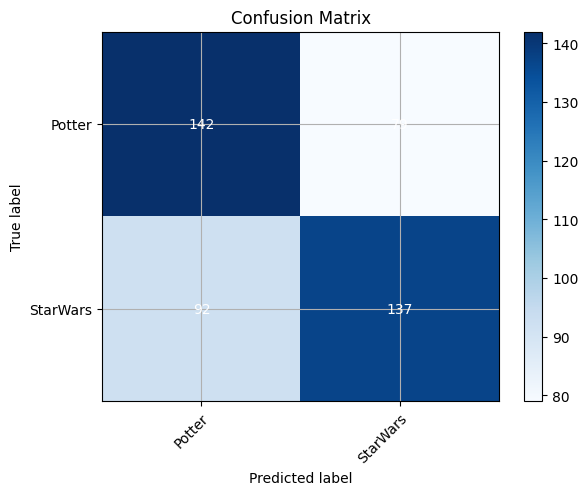

In [ ]:
y_pred = model.predict(X_val)  # Most prevalent prediction
cm = confusion_matrix(y_val, y_pred)

#ploting confusing matrix on validation set
plot_confusion_matrix(cm)


In [ ]:
cm

array([[142,  79],
       [ 92, 137]])

In [ ]:

harry = scaled_data[scaled_data['song_lable']==1]

In [ ]:
h_hum= harry[harry['interpret_lable']==True].iloc[:,0:4]
harry[harry['interpret_lable']==True].describe()

,power,pitch_mean,pitch_std,voiced_fr,song_lable
count,607.000000,607.000000,607.000000,607.000000,607.0
mean,0.052582,-0.465517,0.293116,0.382540,1.0
std,0.949363,0.683784,0.950531,0.727431,0.0
min,-0.823160,-1.598760,-1.625955,-2.297168,1.0
25%,-0.331110,-0.953270,-0.418223,-0.063737,1.0
50%,-0.094815,-0.738526,0.157495,0.488247,1.0
75%,0.202585,0.184277,1.044963,0.887275,1.0
max,13.673513,1.126269,3.919731,1.885504,1.0


In [ ]:
# Filter rows where interpret_lable is True
h_hum = harry[harry['interpret_lable'] == True][['power', 'pitch_mean', 'pitch_std', 'voiced_fr']]

# Check statistics
print(h_hum.describe())


            power  pitch_mean   pitch_std   voiced_fr
count  607.000000  607.000000  607.000000  607.000000
mean     0.052582   -0.465517    0.293116    0.382540
std      0.949363    0.683784    0.950531    0.727431
min     -0.823160   -1.598760   -1.625955   -2.297168
25%     -0.331110   -0.953270   -0.418223   -0.063737
50%     -0.094815   -0.738526    0.157495    0.488247
75%      0.202585    0.184277    1.044963    0.887275
max     13.673513    1.126269    3.919731    1.885504


<Figure size 1000x600 with 0 Axes>

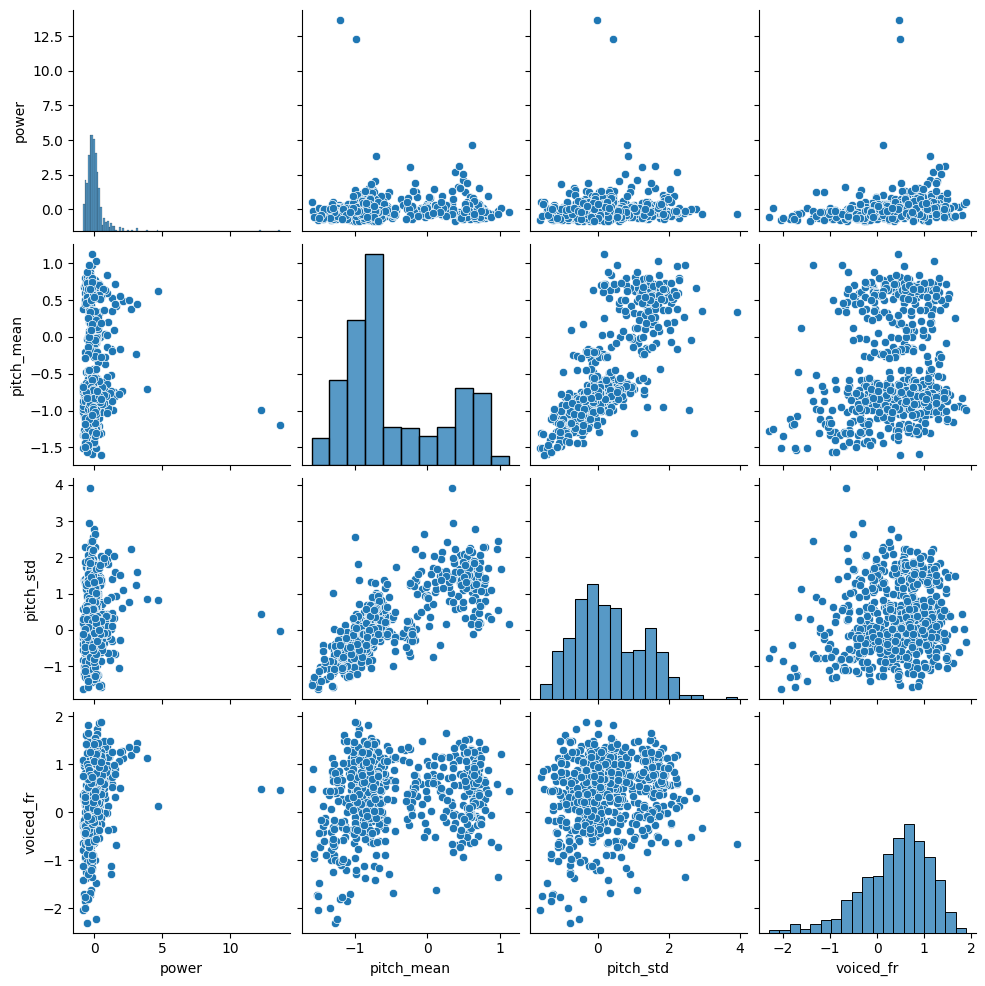

In [ ]:
# Create the default pairplot for humming files of Harry Potter
plt.figure(figsize = (10,6))
sns.pairplot(h_hum)

In [ ]:
h_whistle= harry[harry['interpret_lable']==False].iloc[:, 0:4]
harry[harry['interpret_lable']==False].describe()

,power,pitch_mean,pitch_std,voiced_fr,song_lable
count,231.000000,231.000000,231.000000,231.000000,231.0
mean,-0.062514,1.299175,-0.392411,-0.674878,1.0
std,0.807408,0.397283,0.815740,1.207072,0.0
min,-0.829194,-2.569328,-2.557595,-5.466776,1.0
25%,-0.487769,1.259588,-0.730072,-1.266966,1.0
50%,-0.288571,1.331929,-0.402940,-0.517739,1.0
75%,0.061549,1.416467,-0.103304,0.201565,1.0
max,5.703845,1.675023,5.001016,1.227447,1.0


<Figure size 1000x600 with 0 Axes>

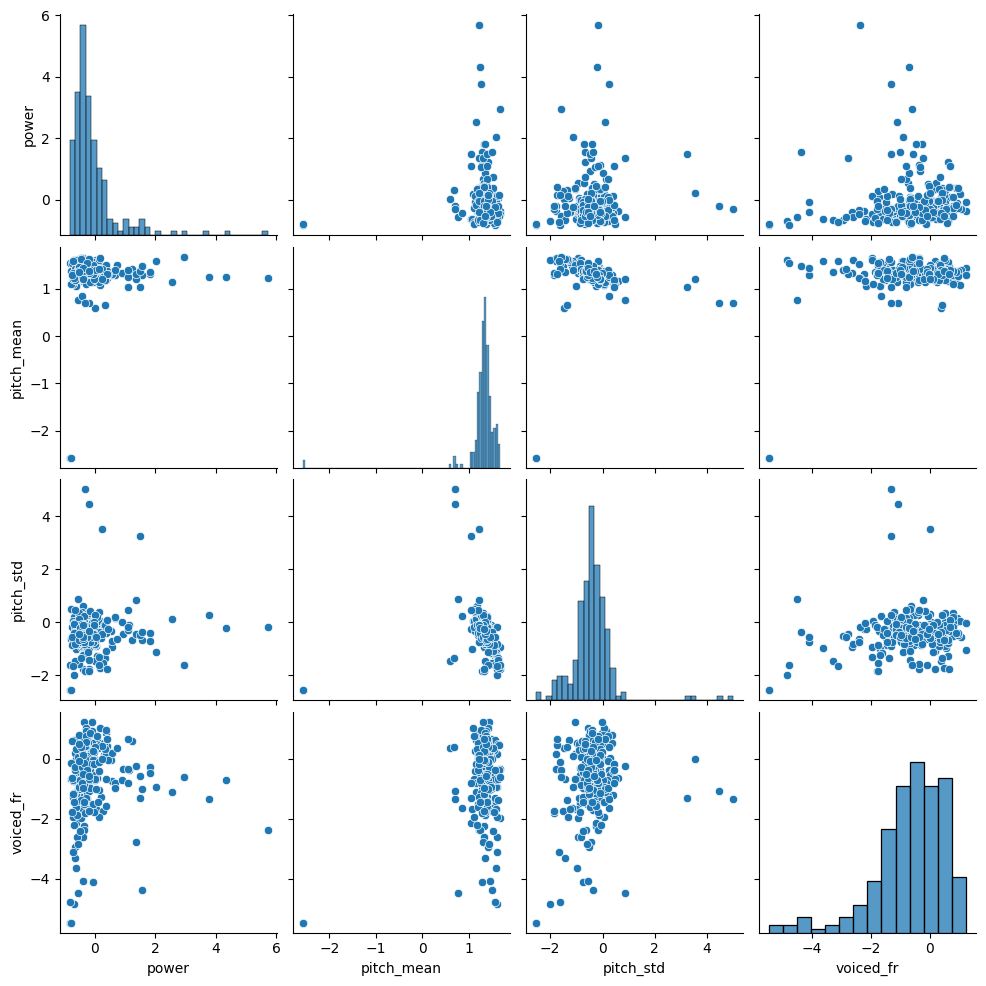

In [ ]:
# Create the default pairplot for whistling files of Harry Potter
plt.figure(figsize = (10,6))
sns.pairplot(h_whistle)

In [ ]:

starwars = scaled_data[scaled_data['song_lable']==3]

In [ ]:
s_hum= starwars[starwars['interpret_lable']==True].iloc[:,0:4]
starwars[starwars['interpret_lable']==True].describe()

,power,pitch_mean,pitch_std,voiced_fr,song_lable
count,605.000000,605.000000,605.000000,605.000000,605.0
mean,-0.021669,-0.523284,0.058239,0.175496,3.0
std,1.126778,0.615010,1.015739,0.686506,0.0
min,-0.814639,-1.572205,-1.858941,-2.859666,3.0
25%,-0.421842,-1.042894,-0.747204,-0.212921,3.0
50%,-0.231655,-0.572635,-0.144262,0.245794,3.0
75%,0.085814,-0.119502,0.905957,0.678437,3.0
max,12.370115,1.066427,2.672628,1.715643,3.0


<Figure size 1000x600 with 0 Axes>

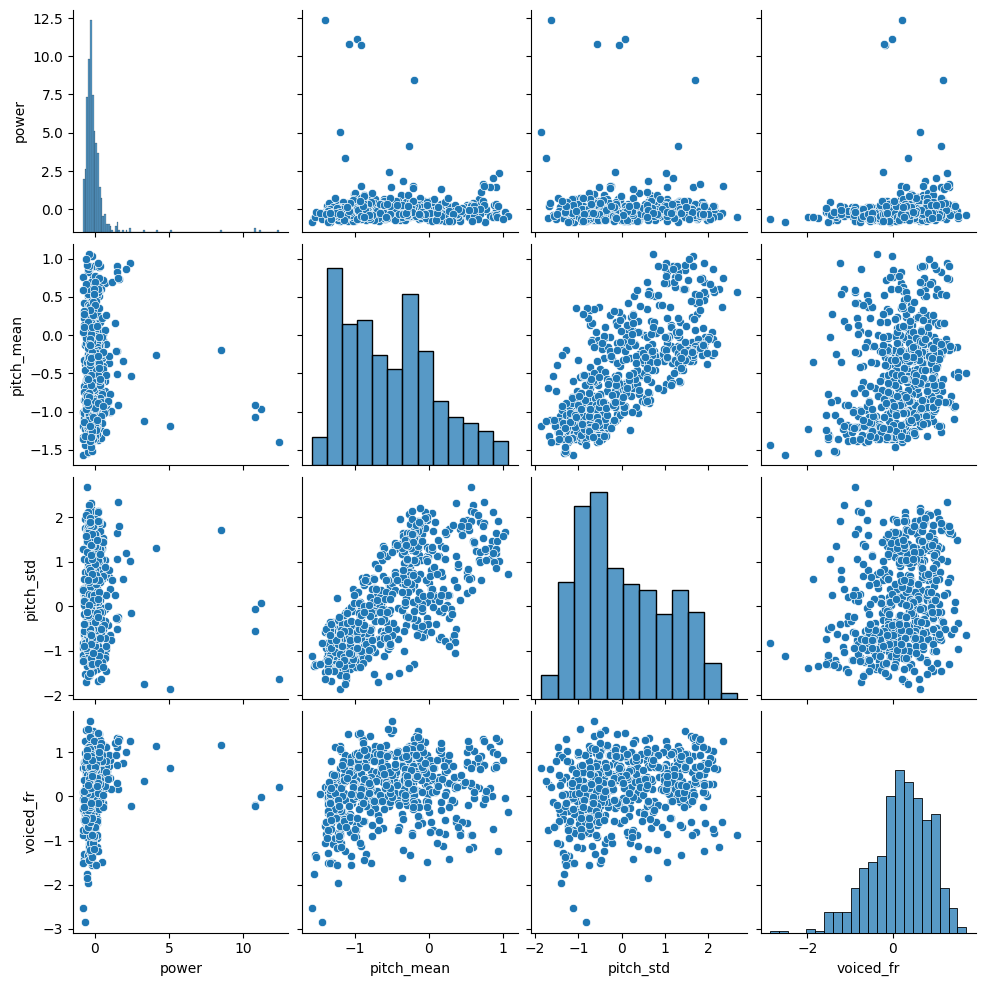

In [ ]:
# Create the default pairplot for humming files of Harry Potter
plt.figure(figsize = (10,6))
sns.pairplot(s_hum)

In [ ]:
s_whistle= starwars[starwars['interpret_lable']==False].iloc[:,0:4]
starwars[starwars['interpret_lable']==False].describe()


,power,pitch_mean,pitch_std,voiced_fr,song_lable
count,226.000000,226.000000,226.000000,226.000000,226.0
mean,-0.019323,1.323212,-0.542074,-0.807433,3.0
std,0.950028,0.411499,0.916708,1.279835,0.0
min,-0.782870,-2.569328,-2.557595,-5.466776,3.0
25%,-0.521244,1.255307,-0.919499,-1.269196,3.0
50%,-0.301655,1.378230,-0.585703,-0.582336,3.0
75%,0.069021,1.463489,-0.244783,0.152894,3.0
max,4.958796,1.681406,5.901700,1.087015,3.0


<Figure size 1000x600 with 0 Axes>

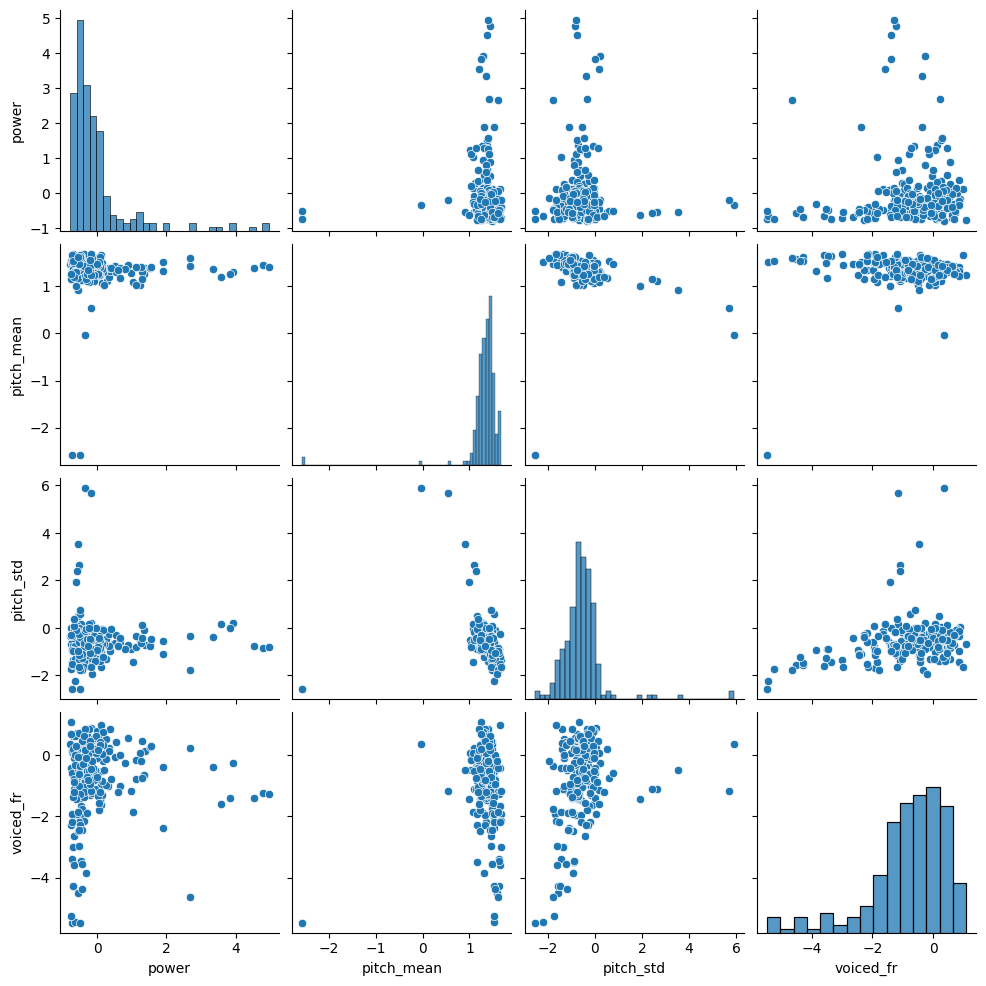

In [ ]:
# Create the default pairplot for humming files of Harry Potter
plt.figure(figsize = (10,6))
sns.pairplot(s_whistle)

In [ ]:
print('Size of testing set:', X_test.shape, y_test.shape)

Size of testing set: (51, 4) (51,)


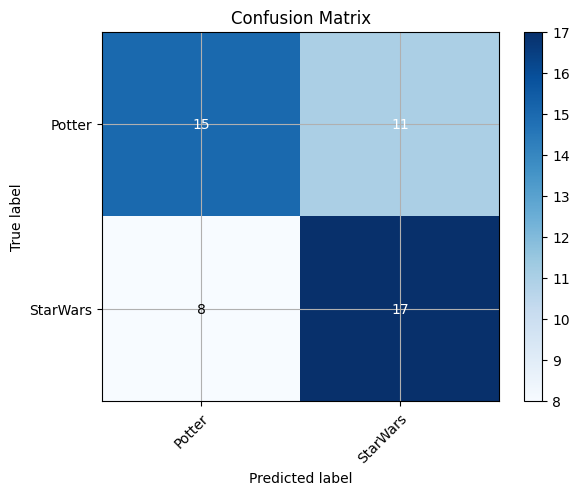

In [ ]:
y_tpred = model.predict(X_test)  # Most prevalent prediction
cm = confusion_matrix(y_test, y_tpred)

#ploting confusing matrix on validation set
plot_confusion_matrix(cm)

In [ ]:

print('Training Accuracy', np.mean(yt_p==y_train))
print('Testing Accuracy', np.mean(y_tpred==y_test))

Training Accuracy 0.6678082191780822
Testing Accuracy 0.6274509803921569


In [ ]:

test_df= X_test
test_df['y_actual']= np.where(y_test == 1, 'Potter', 'StarWars')
test_df['y_predicted']=np.where(y_tpred == 1, 'Potter', 'StarWars')

In [ ]:

test_df[test_df['y_actual']=='Potter']

,power,pitch_mean,pitch_std,voiced_fr,y_actual,y_predicted
767,0.600917,-0.907269,-0.568996,0.773147,Potter,Potter
687,0.499986,-0.814807,-0.862697,1.179330,Potter,Potter
374,-0.690093,1.602076,-1.990364,-4.838502,Potter,StarWars
227,-0.678593,-0.993794,-0.710189,-0.957725,Potter,StarWars
126,-0.184772,0.125510,1.113902,0.710794,Potter,StarWars
16,-0.042963,-0.782819,-0.542630,0.280307,Potter,StarWars
346,0.057085,-0.077771,1.127920,1.472634,Potter,Potter
402,-0.722164,-1.325666,-1.183460,-0.407237,Potter,StarWars
766,-0.052123,1.317298,-0.445336,0.259477,Potter,StarWars
90,0.227624,-0.661672,0.545760,-0.198447,Potter,Potter


In [ ]:
test_df[test_df['y_actual']=='StarWars']

,power,pitch_mean,pitch_std,voiced_fr,y_actual,y_predicted
1635,-0.303586,-0.396182,-1.498689,-0.191985,StarWars,StarWars
929,-0.441537,1.496072,-0.791442,-1.957639,StarWars,StarWars
874,-0.434581,-0.078791,-0.662321,0.573792,StarWars,StarWars
1438,-0.409342,-1.143256,-0.204753,0.459544,StarWars,Potter
1284,-0.463021,1.631520,-0.898969,-3.451213,StarWars,StarWars
1390,0.299839,-0.147873,1.905237,0.506743,StarWars,StarWars
1065,-0.249030,-1.357198,-1.195291,-1.508239,StarWars,StarWars
1418,-0.630642,-0.590794,0.161379,0.583398,StarWars,StarWars
1058,-0.261136,-0.961451,-1.296580,0.432738,StarWars,StarWars
943,-0.549957,-0.030821,0.582207,-0.222941,StarWars,StarWars
